In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

# Building Footprint and Settlement Map

Building footprint and settlement layers were taken from two sources - Openly available [Microsoft Building Footprints] and [Atlas AI's settlement layer](https://storage.googleapis.com/atlasai-public-data/index.html#Morocco_Earthquake_2023/). Points of Interest data were obtained from [OSM](https://data.humdata.org/dataset/hotosm_mar_points_of_interest?) and Earthquake Intensity files were taken from [USGS](https://www.usgs.gov/).



## Methodology

The documentation of data collection and methdology for Atlas Ai can be found [here](https://turkeyeq2023.atlasai.co/). Te datasets are also available on the project [SharePoint](https://worldbankgroup.sharepoint.com.mcas.ms/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=Yvwh8r&cid=fccdf23e%2D94d5%2D48bf%2Db75d%2D0af291138bde&FolderCTID=0x012000CFAB9FF0F938A64EBB297E7E16BDFCFD&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FData%20Lab%2FMorocco%20Economic%20Monitor%20and%20Earthquake%20Impact%2FData&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5). 

The datasets were juxstaposed for the admin regions that were most impacted by the earthquake. The resulting map is interactive with highly granular building footprint data. 

## Limitations

The building footprints are obtained from satellite imagery which is obstructed by cloud cover. Given Morocco is a dessert area, the results are somewhere near 80% accurate. Data from OpenStreetMaps is crowdsourced.


In [2]:
settlement = gpd.read_file('../../data/population/atlasAI/AtlasAI_AHS_Morocco_2022_Built_Up_Settlement_Map.geojson')

In [3]:
morocco_adm2 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_2.shp')
morocco_adm1 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_1.shp')
morocco_adm4= gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_4.shp')
morocco_adm3 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_3.shp')

In [19]:
affected_adm1 = ['Souss - Massa - Draâ', 'Marrakech - Tensift - Al Haouz']
affected_morocco_adm1 = morocco_adm1[morocco_adm1['NAME_1'].isin(affected_adm1)]
affected_adm2 = morocco_adm2[morocco_adm2['NAME_1'].isin(affected_adm1)]
affected_adm3 = morocco_adm3[morocco_adm3['NAME_1'].isin(affected_adm1)]
affected_adm4 = morocco_adm4[morocco_adm4['NAME_1'].isin(affected_adm1)]

In [5]:
affected_settlement = settlement.sjoin(affected_morocco_adm1)

In [35]:
affected_settlement.to_file('../../data/population/atlasAI/affected_settlement.shp')

C:\Users\sahit\AppData\Local\Temp\ipykernel_17832\2825775123.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  affected_settlement.to_file('../../data/population/atlasAI/affected_settlement.shp')


In [13]:
financial_services = gpd.read_file('../../data/poi/hotosm_mar_financial_services_points_shp_shp_uid_36a0ca17-0d63-4977-8063-786fc7a6bf87/hotosm_mar_financial_services_points_shp_point.shp')
financial_services = financial_services.sjoin(affected_morocco_adm1)

In [25]:
poi = gpd.read_file('../../data/poi/hotosm_mar_points_of_interest_points_shp_shp_uid_e08eeee9-52cf-4439-b4d5-a5a5b70d9e94/hotosm_mar_points_of_interest_points_shp_point.shp')

In [38]:
tourist_attractions = poi[~(poi['tourism'].isnull())]
tourist_attractions = tourist_attractions.sjoin(affected_morocco_adm1)

In [20]:
eq_adm4 = pd.read_csv('../../data/earthquake/earthquake_intensity_adm4_gadm.csv')
eq_adm4 = affected_adm4.merge(eq_adm4, on = ['NAME_1', 'NAME_2', 'NAME_3', 'NAME_4'])

In [24]:
eq_adm4.to_file('../../data/earthquake/eq_adm4.shp')

## Impact to financial services and tourist locations

Text(-0.35, -0.05, 'Source: Settlement layer from Atlas AI, earthquake intensity from USGS and Points of Interest from OpenStreetMaps')

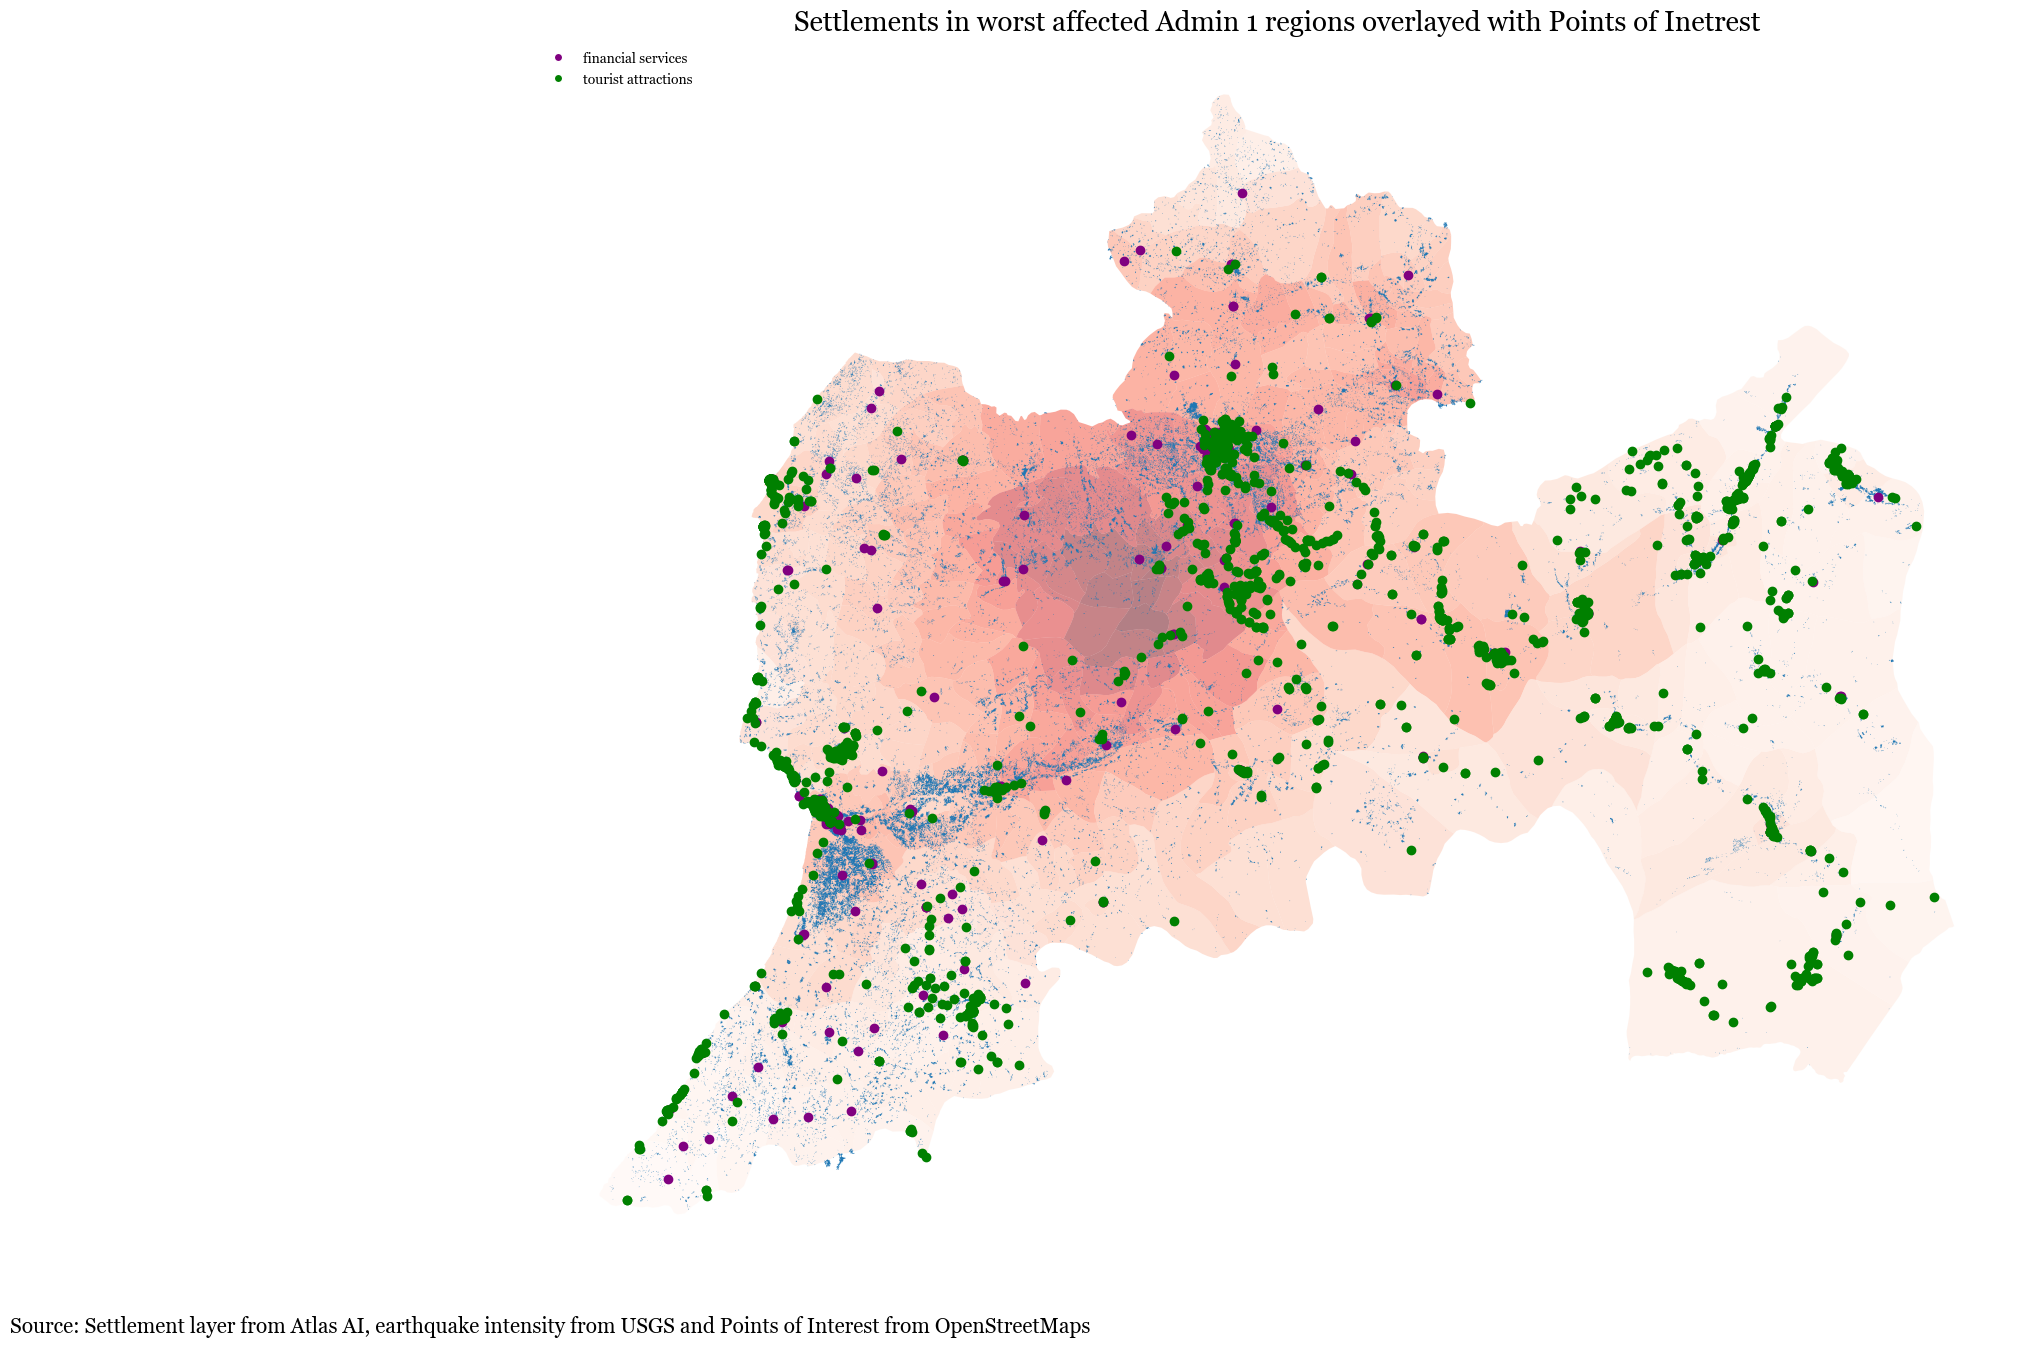

In [43]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

color_dict = {'financial services':'purple', 'tourist attractions':'green'}

fig, ax = plt.subplots(figsize=(20,16))

matplotlib.rcParams['font.family'] = 'Georgia'  # Change 'serif' to your desired font family

eq_adm4.plot(column='PARAMVALUE', ax=ax, cmap = 'Reds', alpha = 0.5)
affected_settlement.plot(ax=ax)
financial_services.plot(color='purple', ax=ax, label = 'financial services')
tourist_attractions.plot(color = 'green', ax=ax)

legend_labels = ['financial services', 'tourist attractions']
handles = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color_dict[label]) for label in legend_labels]
ax.legend(handles=handles, loc='upper left',  frameon=False)

plt.axis('off')

plt.title('Settlements in worst affected Admin 1 regions overlayed with Points of Inetrest', fontsize=20, ha='center')
subtitle_text = "Source: Settlement layer from Atlas AI, earthquake intensity from USGS and Points of Interest from OpenStreetMaps"
ax.text(-0.35, -0.05, subtitle_text, transform=ax.transAxes, fontsize=15, ha='left')


<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/c5888cbb-e1e8-4844-b80f-178cda333a17/embed" frameborder="0" allowfullscreen></iframe>